In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import altair as alt
from markdown import markdown
from IPython.display import Markdown
from ipywidgets.widgets import HTML, Tab
from ipywidgets import widgets
from datetime import timedelta
from matplotlib import pyplot as plt

In [3]:
def author_url(author):
    return f"https://github.com/{author}"

In [4]:
bot_names = ["stale", "codecov", "jupyterlab-dev-mode", "henchbot"]
comments = pd.read_csv('./data/comments.csv', index_col=0).query('author not in @bot_names')
issues = pd.read_csv('./data/issues.csv', index_col=0).query('author not in @bot_names')
prs = pd.read_csv('./data/prs.csv', index_col=0).query('author not in @bot_names')

In [5]:
fmt_date = "{:%Y-%m-%d}"

start_date = comments['updatedAt'].min()
end_date = comments['updatedAt'].max()

renderer = "jupyterlab"
github_orgs = ["jupyterhub", "jupyter", "jupyterlab", "jupyter-widgets", "ipython", "binder-examples", "nteract"]
bot_names = ["stale", "codecov", "jupyterlab-dev-mode", "henchbot"]

In [6]:
alt.renderers.enable(renderer);

In [7]:
# Information about out time window
time_delta = pd.to_datetime(end_date) - pd.to_datetime(start_date)
n_days = time_delta.days

# Information about the data we loaded
github_orgs = comments['org'].unique()

In [8]:
def highlighted_line_plot(data, x, y, color, title, domain=["2019-05-01", "2019-08-01"], legend=True):
    ch = alt.Chart(data=data, width=1000, title=title)

    highlight = alt.selection(type='single', on='mouseover',
                              fields=[color], nearest=True)

    ln = ch.mark_line(clip=True).encode(
        x=alt.X(x, scale=alt.Scale(domain=domain)),
        y=y,
        color=alt.Color(color, legend=legend),
        opacity=alt.condition(~highlight, alt.value(.5), alt.value(1)),
        size=alt.condition(~highlight, alt.value(2), alt.value(5))
    )

    pt = ch.mark_point(clip=True).encode(
        x=alt.X(x, scale=alt.Scale(domain=[start_date, end_date])),
        y=y,
        color=alt.Color(color, legend=legend),
        tooltip=color,
        size=alt.value(300),
        opacity=alt.value(0)
    ).add_selection(highlight).interactive()
    return ln + pt

In [9]:
date_fields = ['updatedAt', 'createdAt', 'closedAt']
for field in date_fields:
    if field in comments.columns:
        comments[field] = pd.to_datetime(comments[field])
    if field in prs.columns:
            prs[field] = pd.to_datetime(prs[field])
    if field in issues.columns:
            issues[field] = pd.to_datetime(issues[field])

In [10]:
from tqdm import tqdm

## Comments over time by people

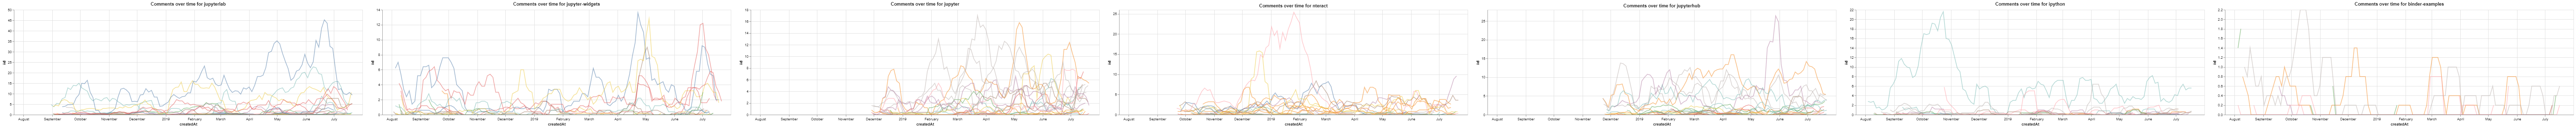

In [10]:
charts = []
for iorg in github_orgs:
    icomments = comments.query('org == @iorg')
    author_comments = icomments.groupby('author').resample('3D', on='createdAt').count()['id'].reset_index()\
        .groupby('author').rolling(5, on='createdAt').mean().reset_index('author')

    n_plot = 20
    top_authors = author_comments.groupby('author').count()['id'].sort_values(ascending=False).head(n_plot).index.values
    author_comments = author_comments.query('author in @top_authors')
    ch = highlighted_line_plot(author_comments, 'createdAt', 'id', 'author', f"Comments over time for {iorg}", legend=None)
    charts.append(ch)
alt.hconcat(*charts)

## Comments over time by repo

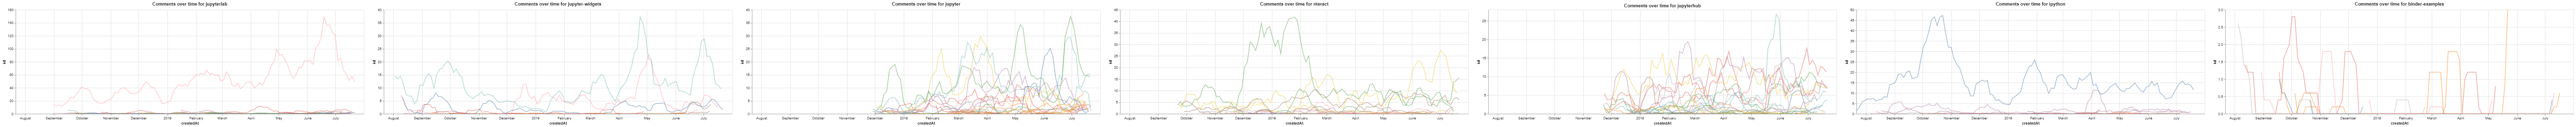

In [11]:
charts = []
for iorg in github_orgs:
    icomments = comments.query('org == @iorg')
    author_comments = icomments.groupby('repo').resample('3D', on='createdAt').count()['id'].reset_index()\
        .groupby('repo').rolling(5, on='createdAt').mean().reset_index('repo')

    n_plot = 20
    top_repos = author_comments.groupby('repo').count()['id'].sort_values(ascending=False).head(n_plot).index.values
    author_comments = author_comments.query('repo in @top_repos')
    ch = highlighted_line_plot(author_comments, 'createdAt', 'id', 'repo', f"Comments over time for {iorg}", legend=None)
    charts.append(ch)
alt.hconcat(*charts)

## Issues +/-

In [11]:
created = issues.groupby(['org', 'repo']).resample('3D', on='createdAt').count()['id'].reset_index().rename(columns={'id': 'created', 'createdAt': 'date'})
closed = issues.dropna(subset=['closedAt']).groupby(['org', 'repo']).resample('3D', on='closedAt').count()['id'].reset_index().rename(columns={'id': 'closed', 'closedAt': 'date'})
issues_activity = pd.merge(created, closed, on=['org', 'repo', 'date'], how='outer')

issues_activity = issues_activity.query('org == "jupyterhub"').groupby('repo', as_index=False)[['created', 'closed']].sum()
issues_activity = pd.melt(issues_activity, id_vars='repo', var_name='kind', value_name='count')

In [12]:
top_repos = issues_activity.groupby(['repo']).sum().sort_values(by='count', ascending=False).head(10).index

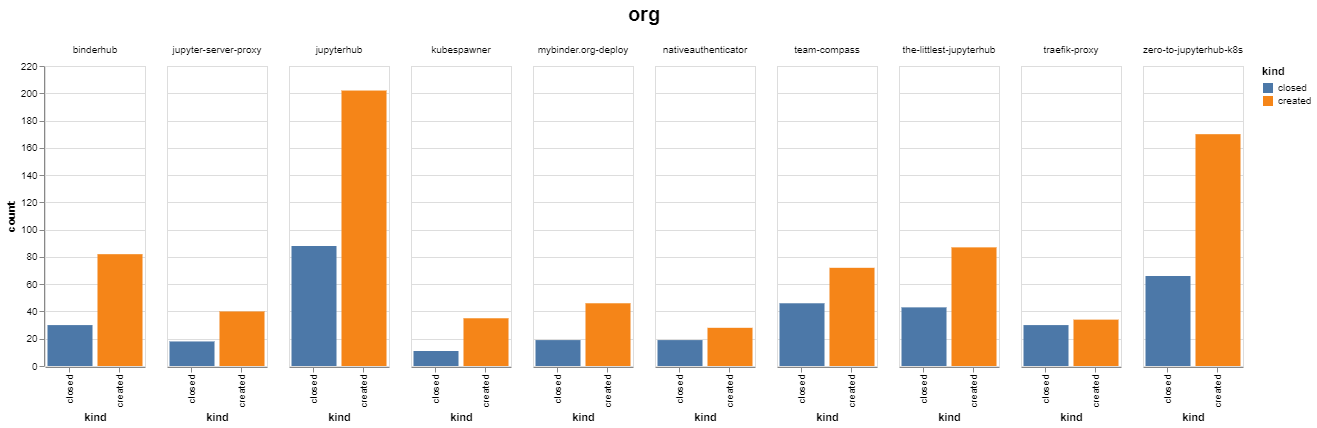

In [21]:
alt.Chart(issues_activity.query('repo in @top_repos'), width=100).mark_bar().encode(
    x='kind', 
    y='count',
    color='kind',
    column=alt.Column("repo", header=alt.Header(titleFontSize=20, title=))
)

In [ ]:
cumulative = issues_activity.set_index(['org', 'repo', 'date'])['net'].unstack(['org', 'repo']).replace(np.nan, 0).cumsum().resample('3D').sum().stack(['org', 'repo']).reset_index()
cumulative = cumulative.rename(columns={0: 'cumulative'})

In [ ]:
charts = []
for iorg in github_orgs:
    i_issues = cumulative.query('cumulative != 0').query('org == @iorg')
    ch = highlighted_line_plot(i_issues, 'date', 'cumulative', 'repo', f"Net issue change over time for {iorg}", legend=None)
    charts.append(ch)
alt.hconcat(*charts)

## Time to first response of issues

In [33]:
first_comments = (comments.groupby(['org', 'repo', 'issue_id'], as_index=False)
                      .agg({'id': 'first', 'createdAt': 'first'})
                      .rename(columns={'createdAt': 'firstResponse', 'issue_id': 'number'})
                      .drop(columns='id')
                 )

In [39]:
issues_w_response = pd.merge(first_comments, issues, on=['org', 'repo', 'number'])
issues_w_response[['createdAt', 'firstResponse']] = issues_w_response[['createdAt', 'firstResponse']].apply(pd.to_datetime)

In [83]:
issues_w_response['time_to_first_response'] = issues_w_response['firstResponse'] - issues_w_response['createdAt']
issues_w_response['hours_to_first_response'] = issues_w_response['time_to_first_response'].map(lambda a: 24 * a.days + a.seconds / 60 / 60)

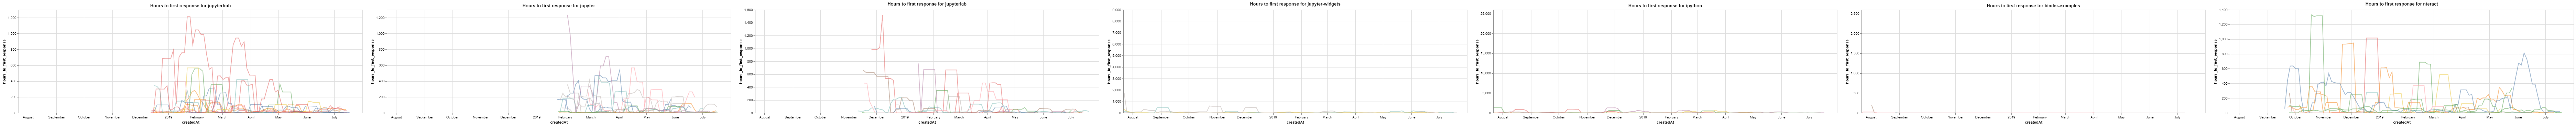

In [91]:
charts = []
for iorg in github_orgs:
    i_issues = issues_w_response.query('org == @iorg')
    author_comments = i_issues.groupby('repo').resample('3D', on='createdAt').median()['hours_to_first_response'].reset_index().replace(np.nan, 0)\
        .groupby('repo').rolling(5, on='createdAt').mean().reset_index('repo')

    n_plot = 20
    top_repos = author_comments.groupby('repo').count()['hours_to_first_response'].sort_values(ascending=False).head(n_plot).index.values
    author_comments = author_comments.query('repo in @top_repos')
    ch = highlighted_line_plot(author_comments, 'createdAt', 'hours_to_first_response', 'repo', f"Hours to first response for {iorg}", legend=None)
    charts.append(ch)
alt.hconcat(*charts)